In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, average_precision_score, f1_score,
    precision_score, recall_score, brier_score_loss, roc_curve
)
from sklearn.feature_selection import (
    SelectKBest, f_classif, RFE, SelectFromModel
)
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Advanced Models
import xgboost as xgb
import lightgbm as lgb

# Statistical Tests
from scipy import stats
from scipy.stats import chi2_contingency, ks_2samp, shapiro

# VIF calculation
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    VIF_AVAILABLE = True
except ImportError:
    VIF_AVAILABLE = False
    print("⚠️ VIF calculation not available. Install statsmodels: pip install statsmodels")

# Model Interpretability
try:
    import shap
    SHAP_AVAILABLE = True
    print("✅ SHAP available for model interpretability")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available. Install with: pip install shap")

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

print("🚀 All packages imported successfully!")
print("📊 Ready for bankruptcy prediction analysis")

# ====================================

✅ SHAP available for model interpretability
🚀 All packages imported successfully!
📊 Ready for bankruptcy prediction analysis


In [3]:



df = pd.read_csv('data.csv')
    
# Basic dataset information
print(f"\n--- DATASET OVERVIEW ---")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]:,}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB")

# Display first few rows
print(f"\n--- FIRST 5 ROWS ---")
display(df.head())



--- DATASET OVERVIEW ---
Rows: 6,819
Columns: 96
Memory usage: 5.0 MB

--- FIRST 5 ROWS ---


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


CLASS DISTRIBUTION ANALYSIS
Non-bankrupt companies (0): 6,599 (96.77%)
Bankrupt companies (1): 220 (3.23%)
Imbalance ratio: 30.0:1


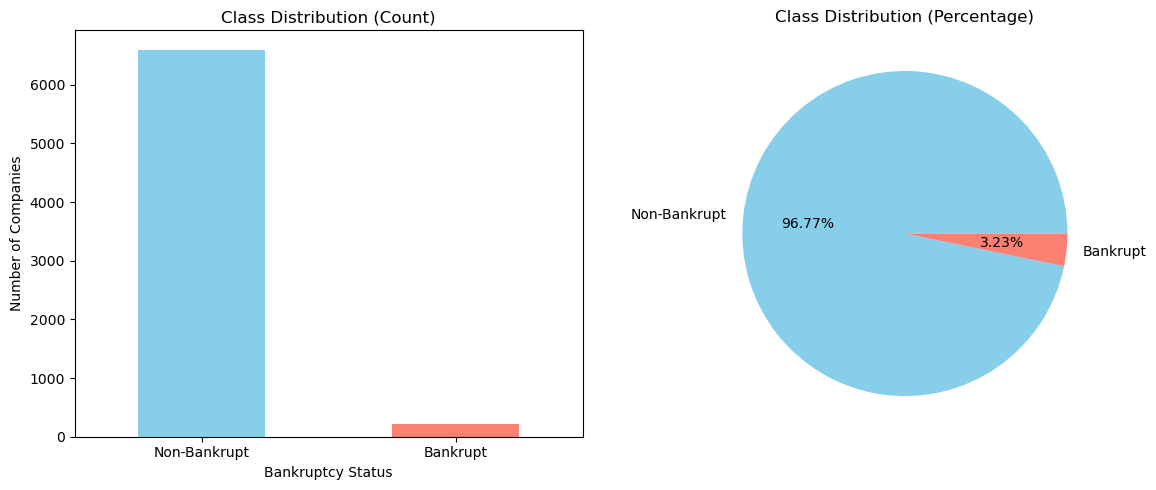


🎯 Imbalance Severity: Severe (30.0:1)
📊 This requires careful handling in model training!


In [4]:
##TARGET VARIABLE ANALYSIS



# Separate target from features
target_col = 'Bankrupt?'
X = df.drop(columns=[target_col])
y = df[target_col]

print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Class distribution
class_counts = y.value_counts()
class_percentages = y.value_counts(normalize=True) * 100

print(f"Non-bankrupt companies (0): {class_counts[0]:,} ({class_percentages[0]:.2f}%)")
print(f"Bankrupt companies (1): {class_counts[1]:,} ({class_percentages[1]:.2f}%)")
print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Class Distribution (Count)')
ax1.set_xlabel('Bankruptcy Status')
ax1.set_ylabel('Number of Companies')
ax1.set_xticklabels(['Non-Bankrupt', 'Bankrupt'], rotation=0)

# Pie chart
ax2.pie(class_counts.values, labels=['Non-Bankrupt', 'Bankrupt'], 
        autopct='%1.2f%%', colors=['skyblue', 'salmon'])
ax2.set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Imbalance severity assessment
imbalance_ratio = class_counts[0] / class_counts[1]
if imbalance_ratio < 3:
    severity = "Mild"
elif imbalance_ratio < 10:
    severity = "Moderate"
elif imbalance_ratio < 100:
    severity = "Severe"
else:
    severity = "Extreme"

print(f"\n🎯 Imbalance Severity: {severity} ({imbalance_ratio:.1f}:1)")
print(f"📊 This requires careful handling in model training!")


In [5]:
# CELL 4: FEATURE ANALYSIS AND DATA QUALITY
# Decision Areas 4, 7: Outlier Detection and Normality Testing


print("="*60)
print("DATA QUALITY ASSESSMENT")
print("="*60)

# Missing values check
missing_info = X.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_info / len(X) * 100).round(2)

print(f"--- MISSING VALUES ---")
if missing_info.sum() == 0:
    print("✅ No missing values detected")
else:
    missing_df = pd.DataFrame({
        'Missing_Count': missing_info[missing_info > 0],
        'Missing_Percentage': missing_pct[missing_pct > 0]
    })
    print(missing_df)

# Feature types
print(f"\n--- FEATURE TYPES ---")
print(f"Numerical features: {X.select_dtypes(include=[np.number]).shape[1]}")
print(f"Categorical features: {X.select_dtypes(exclude=[np.number]).shape[1]}")

# Basic statistics
print(f"\n--- NUMERICAL FEATURE STATISTICS ---")
display(X.describe())

# Outlier detection using IQR method
print(f"\n--- OUTLIER ANALYSIS ---")
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Count outliers per feature
outlier_counts = {}
for col in X.columns:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    outlier_counts[col] = outliers

# Top features with outliers
outlier_df = pd.DataFrame(list(outlier_counts.items()), 
                         columns=['Feature', 'Outlier_Count'])
outlier_df['Outlier_Percentage'] = (outlier_df['Outlier_Count'] / len(X)) * 100
outlier_df = outlier_df.sort_values('Outlier_Count', ascending=False)

print("Top 10 features with most outliers:")
display(outlier_df.head(10))

# Extreme values detection
extreme_features = []
for col in X.columns:
    max_val = X[col].max()
    min_val = X[col].min()
    if abs(max_val) > 1000 or abs(min_val) > 1000:
        extreme_features.append((col, min_val, max_val))

if extreme_features:
    print(f"\n--- EXTREME VALUES (|value| > 1000) ---")
    extreme_df = pd.DataFrame(extreme_features, columns=['Feature', 'Min', 'Max'])
    display(extreme_df.head())
else:
    print(f"\n✅ No extreme values detected")

DATA QUALITY ASSESSMENT
--- MISSING VALUES ---
✅ No missing values detected

--- FEATURE TYPES ---
Numerical features: 95
Categorical features: 0

--- NUMERICAL FEATURE STATISTICS ---


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,0.781567,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,0.781635,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,0.781735,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000



--- OUTLIER ANALYSIS ---
Top 10 features with most outliers:


,Feature,Outlier_Count,Outlier_Percentage
91,Degree of Financial Leverage (DFL),1503,22.041355
92,Interest Coverage Ratio (Interest expense to ...,1421,20.838833
48,Fixed Assets Turnover Frequency,1418,20.794838
70,Current Asset Turnover Rate,1399,20.516205
28,Total Asset Growth Rate,1381,20.252236
34,Interest Expense Ratio,1362,19.973603
80,Cash Flow to Liability,1212,17.773867
87,No-credit Interval,1139,16.703329
8,Non-industry income and expenditure/revenue,1094,16.043408
74,Cash Flow to Sales,1052,15.427482



--- EXTREME VALUES (|value| > 1000) ---


,Feature,Min,Max
0,Operating Expense Rate,0.0,9.990000e+09
1,Research and development expense rate,0.0,9.980000e+09
2,Interest-bearing debt interest rate,0.0,9.900000e+08
3,Revenue Per Share (Yuan ¥),0.0,3.020000e+09
4,Total Asset Growth Rate,0.0,9.990000e+09


NORMALITY TESTING
Testing normality for first 10 features...

Normality Test Results:


,p_value,is_normal,test
ROA(C) before interest and depreciation before interest,0.0,False,D'Agostino-Pearson
ROA(A) before interest and % after tax,0.0,False,D'Agostino-Pearson
ROA(B) before interest and depreciation after tax,0.0,False,D'Agostino-Pearson
Operating Gross Margin,0.0,False,D'Agostino-Pearson
Realized Sales Gross Margin,0.0,False,D'Agostino-Pearson
Operating Profit Rate,0.0,False,D'Agostino-Pearson
Pre-tax net Interest Rate,0.0,False,D'Agostino-Pearson
After-tax net Interest Rate,0.0,False,D'Agostino-Pearson
Non-industry income and expenditure/revenue,0.0,False,D'Agostino-Pearson
Continuous interest rate (after tax),0.0,False,D'Agostino-Pearson



📊 Normality Summary:
Features tested: 10
Normal features (p > 0.05): 0
Non-normal features: 10
Percentage normal: 0.0%


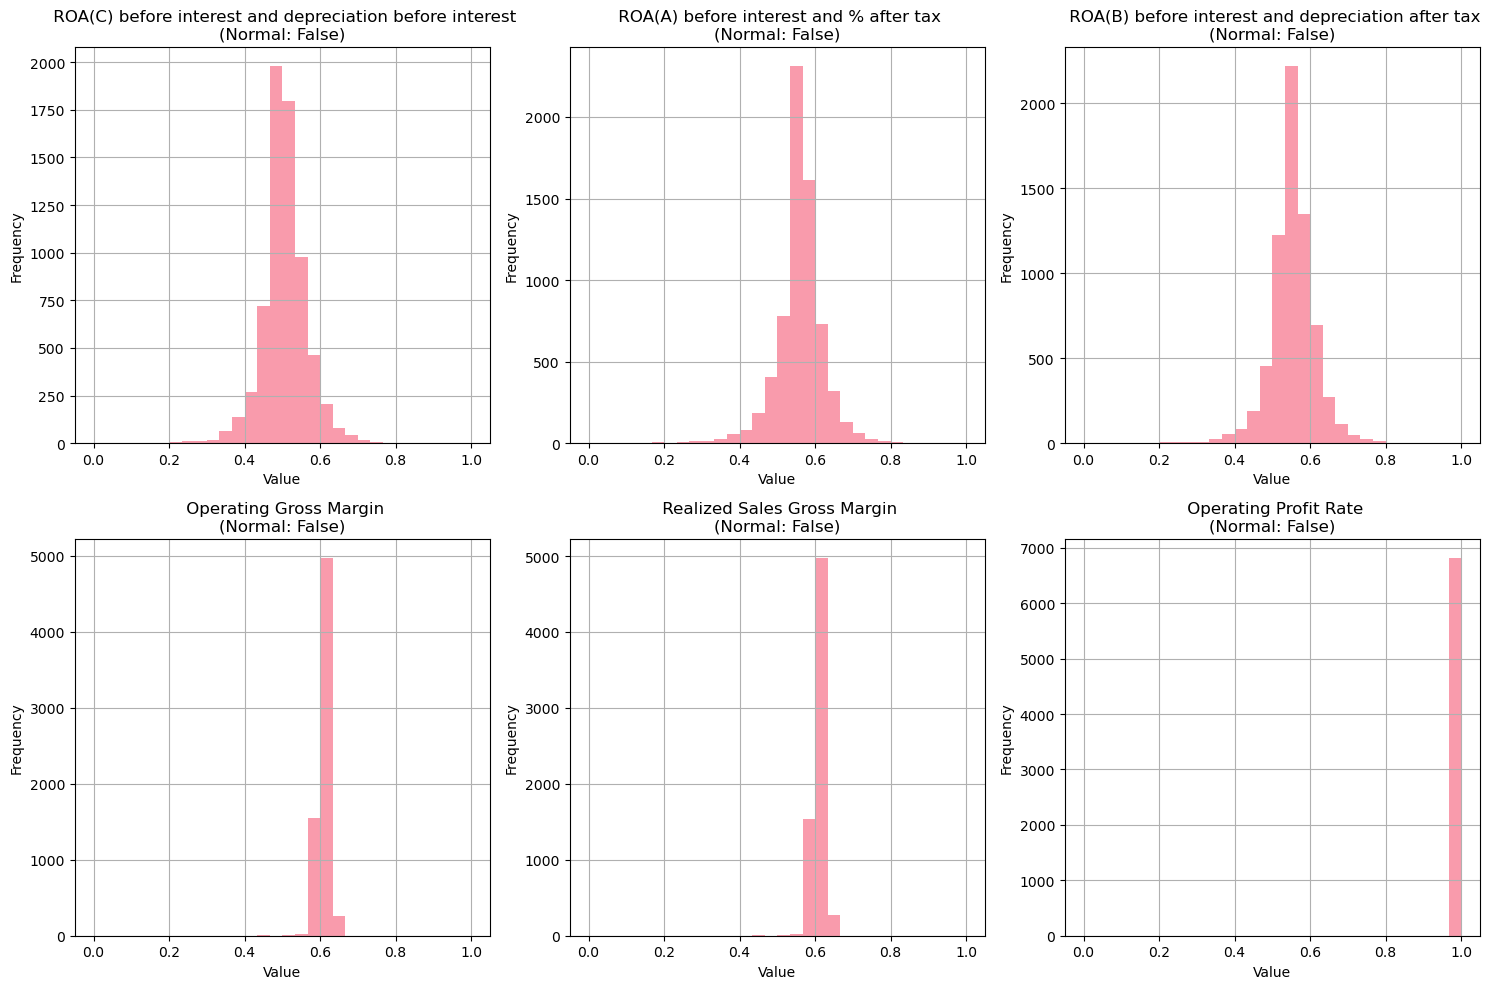

In [6]:
# CELL 5: NORMALITY TESTING
# Decision Area 7: Testing for Normality

"""
NORMALITY TESTING ANALYSIS
- Test subset of features for normality
- Understand distribution patterns
- Guide preprocessing decisions
"""

print("="*60)
print("NORMALITY TESTING")
print("="*60)

# Test normality for sample of features (testing all would be computationally expensive)
sample_features = X.columns[:10]  # First 10 features
normality_results = {}

print("Testing normality for first 10 features...")

for feature in sample_features:
    # Use different tests based on sample size
    try:
        if len(X) <= 5000:
            # Shapiro-Wilk test for smaller samples
            stat, p_value = shapiro(X[feature].dropna())
            test_used = "Shapiro-Wilk"
        else:
            # Anderson-Darling test for larger samples
            from scipy.stats import normaltest
            stat, p_value = normaltest(X[feature].dropna())
            test_used = "D'Agostino-Pearson"
        
        normality_results[feature] = {
            'statistic': stat,
            'p_value': p_value,
            'is_normal': p_value > 0.05,
            'test': test_used
        }
    except Exception as e:
        print(f"⚠️ Error testing {feature}: {str(e)}")
        continue

# Display results
normality_df = pd.DataFrame(normality_results).T
normality_df['is_normal'] = normality_df['p_value'] > 0.05

print(f"\nNormality Test Results:")
display(normality_df[['p_value', 'is_normal', 'test']])

# Summary
normal_count = normality_df['is_normal'].sum()
total_tested = len(normality_df)

print(f"\n📊 Normality Summary:")
print(f"Features tested: {total_tested}")
print(f"Normal features (p > 0.05): {normal_count}")
print(f"Non-normal features: {total_tested - normal_count}")
print(f"Percentage normal: {(normal_count/total_tested)*100:.1f}%")

# Visualization of distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(sample_features[:6]):
    X[feature].hist(bins=30, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{feature}\n(Normal: {normality_results.get(feature, {}).get("is_normal", "Unknown")})')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

MULTICOLLINEARITY ANALYSIS
Highly correlated feature pairs (|r| > 0.8):
Found 43 pairs

Top 10 highest correlations:


,Feature_1,Feature_2,Correlation
39,Current Liabilities/Equity,Current Liability to Equity,1.000000
38,Current Liabilities/Liability,Current Liability to Liability,1.000000
29,Debt ratio %,Net worth/Assets,1.000000
7,Operating Gross Margin,Gross Profit to Sales,1.000000
18,Net Value Per Share (A),Net Value Per Share (C),0.999837
6,Operating Gross Margin,Realized Sales Gross Margin,0.999518
8,Realized Sales Gross Margin,Gross Profit to Sales,0.999518
16,Net Value Per Share (B),Net Value Per Share (A),0.999342
17,Net Value Per Share (B),Net Value Per Share (C),0.999179
24,Operating Profit Per Share (Yuan ¥),Operating profit/Paid-in capital,0.998696


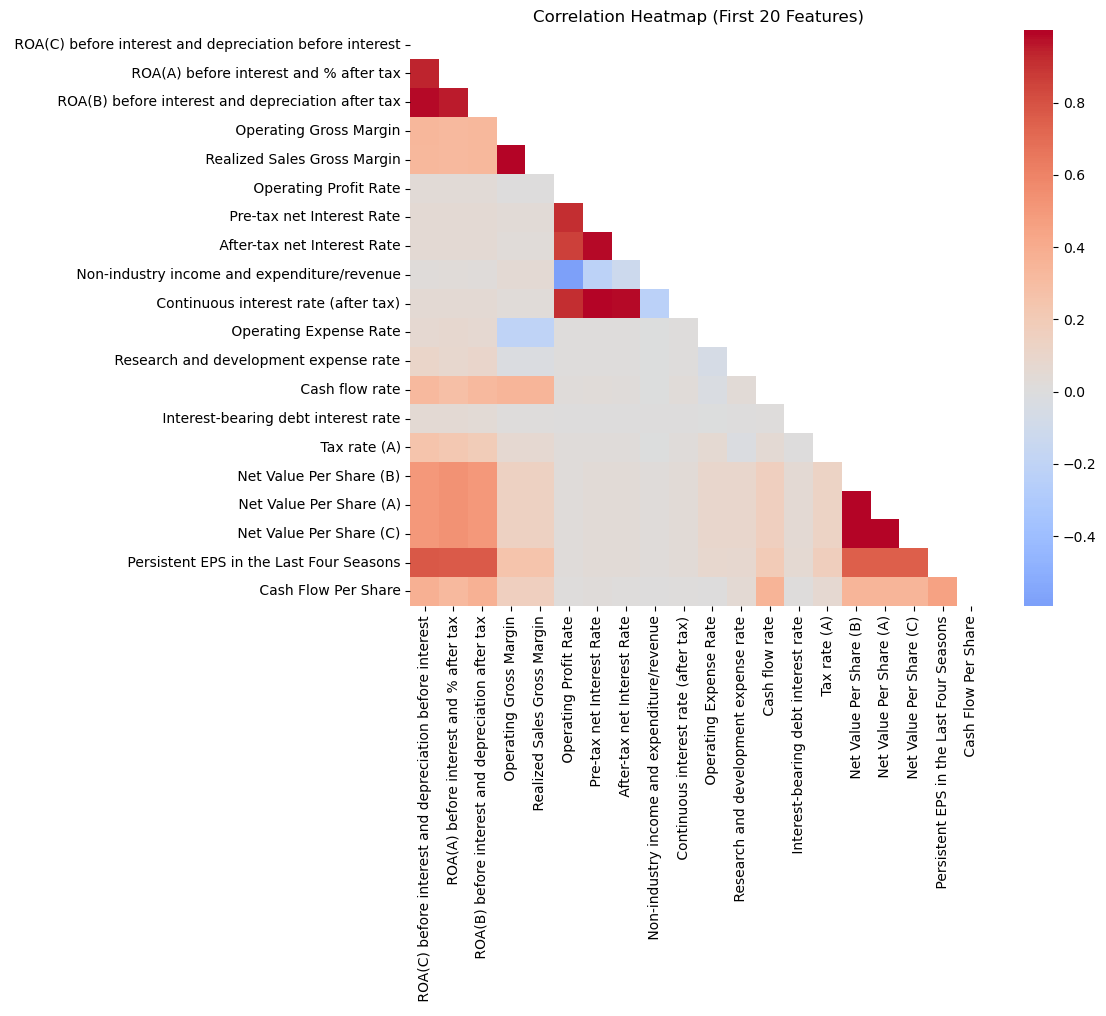


--- VIF ANALYSIS ---
VIF Analysis (subset of 15 features):


,Feature,VIF
6,Pre-tax net Interest Rate,464128.482673
7,After-tax net Interest Rate,262493.929571
5,Operating Profit Rate,42346.445299
2,ROA(B) before interest and depreciation after...,4858.433708
0,ROA(C) before interest and depreciation befor...,3140.848300
3,Operating Gross Margin,1044.859031
4,Realized Sales Gross Margin,1043.668773
1,ROA(A) before interest and % after tax,889.778173
9,Continuous interest rate (after tax),94.946405
14,Tax rate (A),2.071097



Features with VIF > 5 (multicollinearity concern): 9


,Feature,VIF
6,Pre-tax net Interest Rate,464128.482673
7,After-tax net Interest Rate,262493.929571
5,Operating Profit Rate,42346.445299
2,ROA(B) before interest and depreciation after...,4858.433708
0,ROA(C) before interest and depreciation befor...,3140.848300
3,Operating Gross Margin,1044.859031
4,Realized Sales Gross Margin,1043.668773
1,ROA(A) before interest and % after tax,889.778173
9,Continuous interest rate (after tax),94.946405


In [7]:
# CELL 6: MULTICOLLINEARITY ANALYSIS
# Decision Area 10: Testing and Addressing Multicollinearity


print("="*60)
print("MULTICOLLINEARITY ANALYSIS")
print("="*60)

# Calculate correlation matrix for numeric features
numeric_features = X.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()

# Find highly correlated pairs
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = abs(correlation_matrix.iloc[i, j])
        if corr_val > high_corr_threshold:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

print(f"Highly correlated feature pairs (|r| > {high_corr_threshold}):")
print(f"Found {len(high_corr_pairs)} pairs")

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)
    print("\nTop 10 highest correlations:")
    display(high_corr_df.head(10))
    
    # Visualize correlation heatmap for subset
    plt.figure(figsize=(12, 10))
    # Use subset for visualization
    subset_features = numeric_features.columns[:20]  # First 20 features
    subset_corr = numeric_features[subset_features].corr()
    
    mask = np.triu(np.ones_like(subset_corr, dtype=bool))
    sns.heatmap(subset_corr, mask=mask, annot=False, cmap='coolwarm', 
                center=0, square=True, fmt='.2f')
    plt.title('Correlation Heatmap (First 20 Features)')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No highly correlated pairs found")

# VIF Analysis (if available)
if VIF_AVAILABLE:
    print(f"\n--- VIF ANALYSIS ---")
    try:
        # Calculate VIF for subset (computationally expensive)
        vif_features = numeric_features.columns[:15]  # Limit to 15 features
        X_vif = numeric_features[vif_features]
        
        # Remove features with zero variance
        X_vif = X_vif.loc[:, X_vif.var() > 0]
        
        vif_data = []
        for i, feature in enumerate(X_vif.columns):
            try:
                vif = variance_inflation_factor(X_vif.values, i)
                if not np.isnan(vif) and not np.isinf(vif):
                    vif_data.append({'Feature': feature, 'VIF': vif})
            except:
                continue
        
        if vif_data:
            vif_df = pd.DataFrame(vif_data)
            vif_df = vif_df.sort_values('VIF', ascending=False)
            
            print(f"VIF Analysis (subset of {len(X_vif.columns)} features):")
            display(vif_df)
            
            high_vif = vif_df[vif_df['VIF'] > 5]
            print(f"\nFeatures with VIF > 5 (multicollinearity concern): {len(high_vif)}")
            if len(high_vif) > 0:
                display(high_vif)
        else:
            print("⚠️ Could not calculate VIF values")
            
    except Exception as e:
        print(f"⚠️ VIF calculation failed: {str(e)}")
else:
    print(f"\n⚠️ VIF analysis not available (statsmodels not installed)")


DATA PREPROCESSING STRATEGIES
Available preprocessing methods:
- none: No scaling
- standard: StandardScaler
- robust: RobustScaler


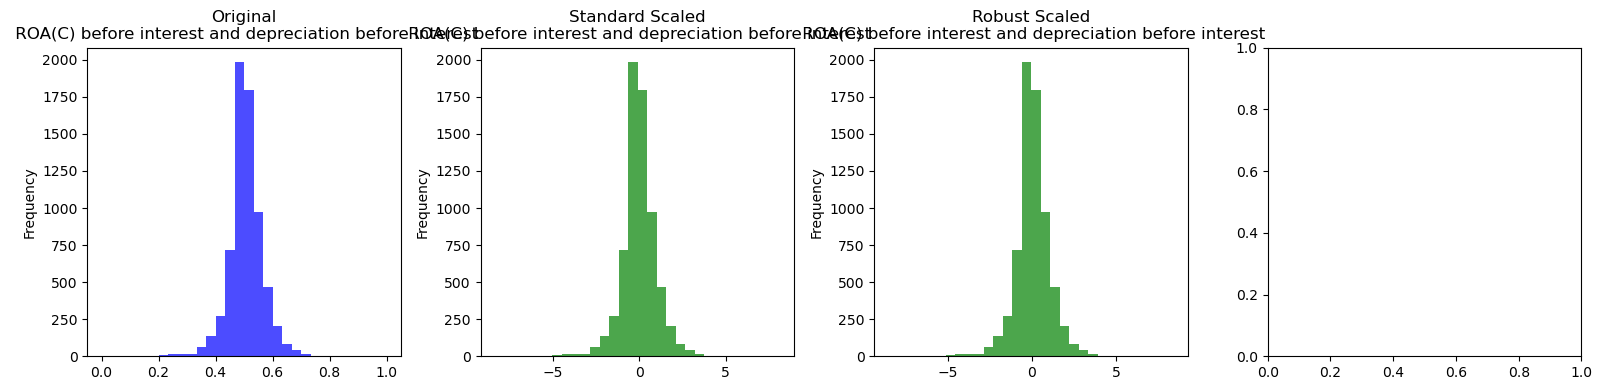


Scaling Effect on  ROA(C) before interest and depreciation before interest:
Original: mean=0.505, std=0.061
Standard: mean=-0.000, std=1.000
Robust: mean=0.042, std=1.028


In [8]:

# CELL 7: DATA PREPROCESSING STRATEGIES
# Decision Areas 2, 6: Data Preprocessing and Normalization


print("="*60)
print("DATA PREPROCESSING STRATEGIES")
print("="*60)

# Define preprocessing options
preprocessing_options = {
    'none': None,
    'standard': StandardScaler(),
    'robust': RobustScaler()  # Less sensitive to outliers
}

print("Available preprocessing methods:")
for name, scaler in preprocessing_options.items():
    if scaler is None:
        print(f"- {name}: No scaling")
    else:
        print(f"- {name}: {type(scaler).__name__}")

# Demonstrate effect of different scaling methods
sample_feature = X.columns[0]  # First feature for demonstration
sample_data = X[sample_feature].values.reshape(-1, 1)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original data
axes[0].hist(sample_data, bins=30, alpha=0.7, color='blue')
axes[0].set_title(f'Original\n{sample_feature}')
axes[0].set_ylabel('Frequency')

# Apply different scaling methods
for i, (name, scaler) in enumerate(list(preprocessing_options.items())[1:], 1):
    if scaler is not None:
        scaled_data = scaler.fit_transform(sample_data)
        axes[i].hist(scaled_data, bins=30, alpha=0.7, color='green')
        axes[i].set_title(f'{name.title()} Scaled\n{sample_feature}')
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compare statistics before and after scaling
print(f"\nScaling Effect on {sample_feature}:")
print(f"Original: mean={sample_data.mean():.3f}, std={sample_data.std():.3f}")

for name, scaler in preprocessing_options.items():
    if scaler is not None:
        scaled = scaler.fit_transform(sample_data)
        print(f"{name.title()}: mean={scaled.mean():.3f}, std={scaled.std():.3f}")


DATA SPLITTING AND STRATIFICATION
Training set: 5,455 samples
Test set: 1,364 samples

--- CLASS DISTRIBUTION COMPARISON ---


,Original,Training,Test,Training_Diff,Test_Diff
Bankrupt?,,,,,
0,0.967737,0.967736,0.967742,0.000001,0.000005
1,0.032263,0.032264,0.032258,0.000001,0.000005


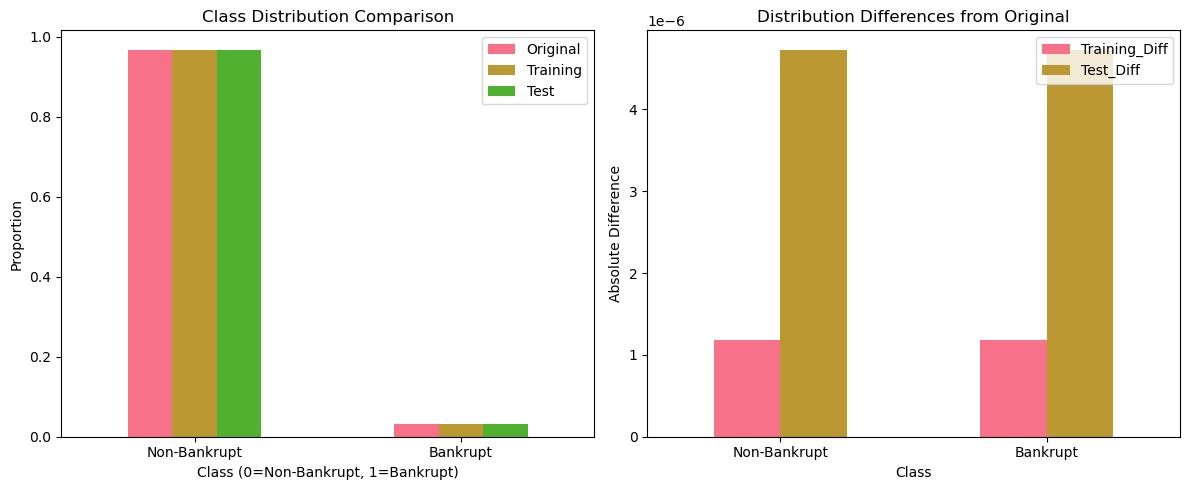


--- FEATURE DISTRIBUTION SIMILARITY TEST ---
Testing distribution similarity for 10 features using Kolmogorov-Smirnov test:
 ROA(C) before interest and depreciation before interest: p=0.0142 ⚠️ Different
 ROA(A) before interest and % after tax: p=0.0132 ⚠️ Different
 ROA(B) before interest and depreciation after tax: p=0.0432 ⚠️ Different
 Operating Gross Margin: p=0.9352 ✅ Similar
 Realized Sales Gross Margin: p=0.8344 ✅ Similar
 Operating Profit Rate: p=0.1684 ✅ Similar
 Pre-tax net Interest Rate: p=0.0239 ⚠️ Different
 After-tax net Interest Rate: p=0.0658 ✅ Similar
 Non-industry income and expenditure/revenue: p=0.1164 ✅ Similar
 Continuous interest rate (after tax): p=0.0275 ⚠️ Different

Summary: 5/10 features have similar distributions
Similarity rate: 50.0%
⚠️ Some distribution differences detected - monitor model performance


In [9]:


# CELL 8: TRAIN-TEST SPLIT AND STRATIFICATION
# Decision Areas 5, 14: Sampling Bias and Cross-Validation Strategy



print("="*60)
print("DATA SPLITTING AND STRATIFICATION")
print("="*60)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Verify class distribution preservation
train_dist = y_train.value_counts(normalize=True)
test_dist = y_test.value_counts(normalize=True)
original_dist = y.value_counts(normalize=True)

print(f"\n--- CLASS DISTRIBUTION COMPARISON ---")
distribution_df = pd.DataFrame({
    'Original': original_dist,
    'Training': train_dist,
    'Test': test_dist
})
distribution_df['Training_Diff'] = abs(distribution_df['Training'] - distribution_df['Original'])
distribution_df['Test_Diff'] = abs(distribution_df['Test'] - distribution_df['Original'])

display(distribution_df)

# Visualize distribution preservation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot comparison
distribution_df[['Original', 'Training', 'Test']].plot(kind='bar', ax=ax1)
ax1.set_title('Class Distribution Comparison')
ax1.set_xlabel('Class (0=Non-Bankrupt, 1=Bankrupt)')
ax1.set_ylabel('Proportion')
ax1.legend()
ax1.set_xticklabels(['Non-Bankrupt', 'Bankrupt'], rotation=0)

# Difference plot
distribution_df[['Training_Diff', 'Test_Diff']].plot(kind='bar', ax=ax2)
ax2.set_title('Distribution Differences from Original')
ax2.set_xlabel('Class')
ax2.set_ylabel('Absolute Difference')
ax2.legend()
ax2.set_xticklabels(['Non-Bankrupt', 'Bankrupt'], rotation=0)

plt.tight_layout()
plt.show()

# Statistical test for feature distribution similarity (PSI concept)
print(f"\n--- FEATURE DISTRIBUTION SIMILARITY TEST ---")
similar_features = 0
total_tested = min(10, len(X.columns))

print(f"Testing distribution similarity for {total_tested} features using Kolmogorov-Smirnov test:")

for col in X.columns[:total_tested]:
    ks_stat, p_value = ks_2samp(X_train[col], X_test[col])
    is_similar = p_value > 0.05
    if is_similar:
        similar_features += 1
    status = "✅ Similar" if is_similar else "⚠️ Different"
    print(f"{col}: p={p_value:.4f} {status}")

print(f"\nSummary: {similar_features}/{total_tested} features have similar distributions")
print(f"Similarity rate: {(similar_features/total_tested)*100:.1f}%")

if similar_features / total_tested > 0.8:
    print("✅ Good distribution similarity between train/test sets")
else:
    print("⚠️ Some distribution differences detected - monitor model performance")

CLASS IMBALANCE HANDLING STRATEGIES
Available sampling strategies:
- none: No resampling (baseline)
- smote: SMOTE
- smote_enn: SMOTEENN
- smote_tomek: SMOTETomek
- borderline_smote: BorderlineSMOTE
- random_undersampling: RandomUnderSampler
- cluster_undersampling: ClusterCentroids

--- SAMPLING DEMONSTRATION ---
Original training set: {0: 5279, 1: 176}

Sampling Results Comparison:


,samples,class_0,class_1,ratio,balance_improvement
none,5455.0,5279.0,176.0,29.994318,False
smote,10558.0,5279.0,5279.0,1.000000,True
smote_enn,9338.0,4341.0,4997.0,0.868721,True
smote_tomek,10500.0,5250.0,5250.0,1.000000,True
borderline_smote,10558.0,5279.0,5279.0,1.000000,True
random_undersampling,352.0,176.0,176.0,1.000000,True
cluster_undersampling,352.0,176.0,176.0,1.000000,True


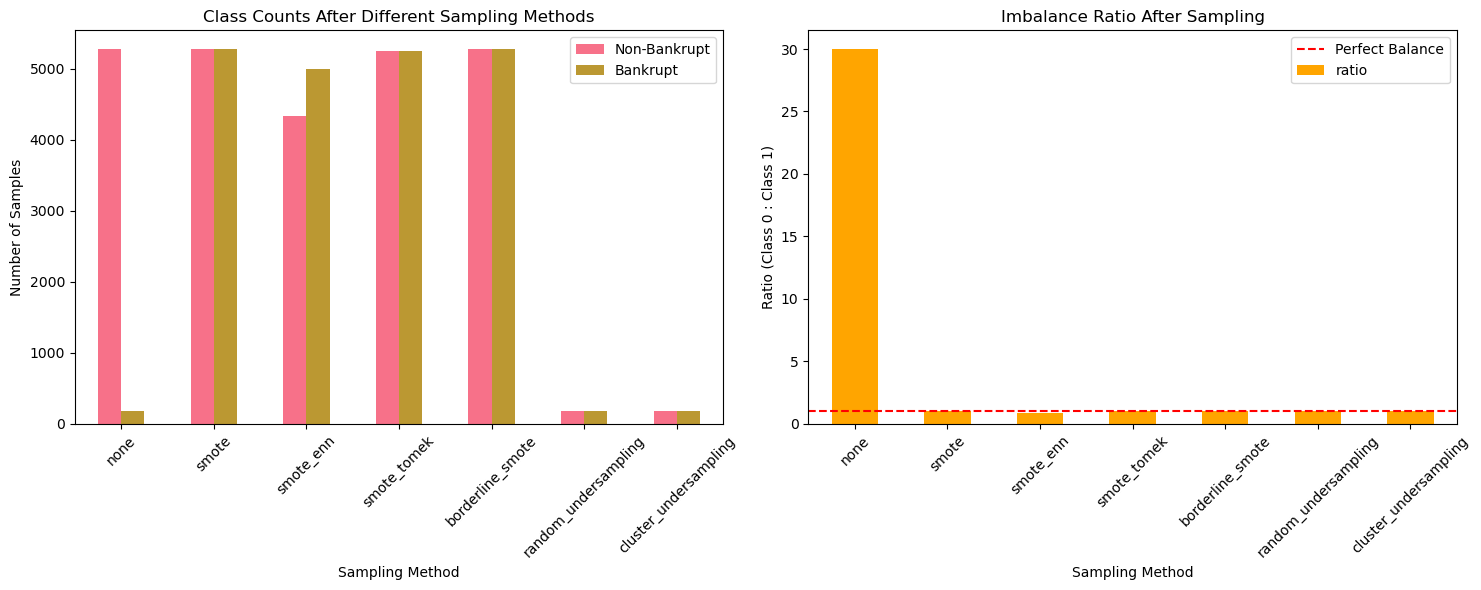

In [10]:

# CELL 9: CLASS IMBALANCE HANDLING STRATEGIES
# Decision Area 3: Handling Class Imbalance (Detailed Implementation)


"""
DECISION AREA 3: CLASS IMBALANCE HANDLING STRATEGIES
- Define multiple sampling techniques
- Compare different approaches
- Prepare for model training
"""

print("="*60)
print("CLASS IMBALANCE HANDLING STRATEGIES")
print("="*60)

# Define sampling strategies
sampling_strategies = {
    'none': None,
    'smote': SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    'smote_enn': SMOTEENN(random_state=RANDOM_STATE),
    'smote_tomek': SMOTETomek(random_state=RANDOM_STATE),
    'borderline_smote': BorderlineSMOTE(random_state=RANDOM_STATE),
    'random_undersampling': RandomUnderSampler(random_state=RANDOM_STATE),
    'cluster_undersampling': ClusterCentroids(random_state=RANDOM_STATE)
}

print("Available sampling strategies:")
for name, strategy in sampling_strategies.items():
    if strategy is None:
        print(f"- {name}: No resampling (baseline)")
    else:
        print(f"- {name}: {type(strategy).__name__}")

# Demonstrate effect of different sampling techniques
print(f"\n--- SAMPLING DEMONSTRATION ---")
print(f"Original training set: {y_train.value_counts().to_dict()}")

# Apply each sampling technique and show results
sampling_results = {}

for name, sampler in sampling_strategies.items():
    if sampler is None:
        # No sampling
        X_resampled = X_train
        y_resampled = y_train
    else:
        try:
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        except Exception as e:
            print(f"⚠️ Error with {name}: {str(e)}")
            continue
    
    # Store results
    resampled_counts = pd.Series(y_resampled).value_counts().sort_index()
    sampling_results[name] = {
        'samples': len(y_resampled),
        'class_0': resampled_counts.get(0, 0),
        'class_1': resampled_counts.get(1, 0),
        'ratio': resampled_counts.get(0, 0) / resampled_counts.get(1, 1) if resampled_counts.get(1, 0) > 0 else np.inf
    }

# Display sampling results
sampling_df = pd.DataFrame(sampling_results).T
sampling_df['balance_improvement'] = sampling_df['ratio'] < (y_train.value_counts()[0] / y_train.value_counts()[1])

print(f"\nSampling Results Comparison:")
display(sampling_df)

# Visualize sampling effects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sample counts
sampling_df[['class_0', 'class_1']].plot(kind='bar', ax=ax1)
ax1.set_title('Class Counts After Different Sampling Methods')
ax1.set_xlabel('Sampling Method')
ax1.set_ylabel('Number of Samples')
ax1.legend(['Non-Bankrupt', 'Bankrupt'])
ax1.tick_params(axis='x', rotation=45)

# Imbalance ratios
sampling_df['ratio'].plot(kind='bar', ax=ax2, color='orange')
ax2.set_title('Imbalance Ratio After Sampling')
ax2.set_xlabel('Sampling Method')
ax2.set_ylabel('Ratio (Class 0 : Class 1)')
ax2.axhline(y=1, color='red', linestyle='--', label='Perfect Balance')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



FEATURE SELECTION METHODS
Available feature selection methods:
- none: No feature selection (use all 95 features)
- k_best_10: SelectKBest
  → Selects 10 features
- k_best_20: SelectKBest
  → Selects 20 features
- k_best_50: SelectKBest
  → Selects 50 features
- rfe_20: RFE
  → Selects 20 features
- lasso_selection: SelectFromModel

--- FEATURE SELECTION DEMONSTRATION ---
none: 95 features selected
  First 5 features: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin']
k_best_10: 10 features selected
  Features: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Persistent EPS in the Last Four Seasons', ' Debt ratio %', ' Net worth/Assets', ' Net profit before tax/Paid-in capital', ' Retained Earnings to Total Assets

,n_features
k_best_10,10
k_best_20,20
k_best_50,50
rfe_20,20
lasso_selection,30


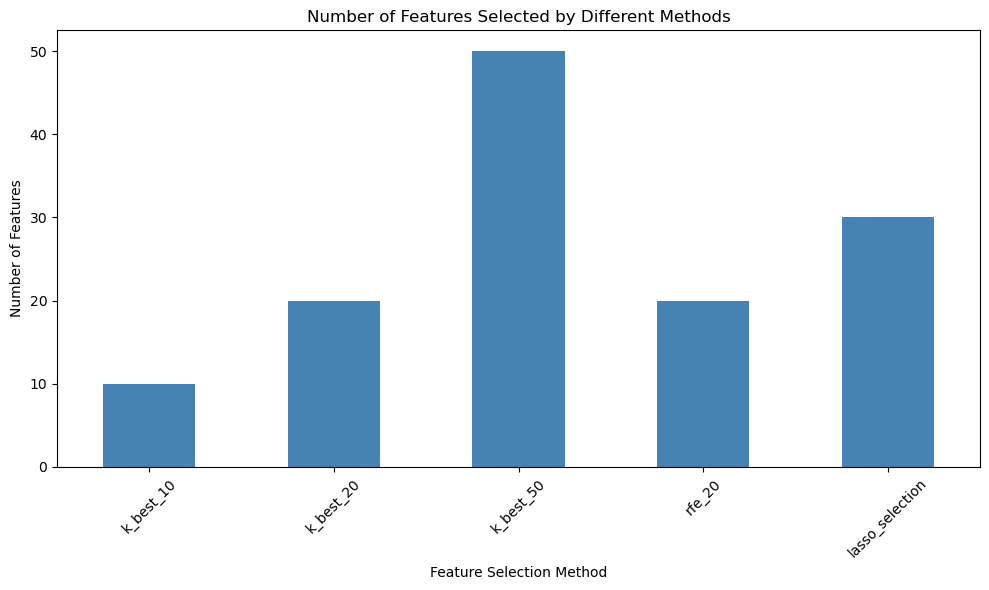


--- FEATURE IMPORTANCE ANALYSIS ---
Top 15 most important features (Random Forest):


,feature,importance
89,Net Income to Stockholder's Equity,0.037982
39,Borrowing dependency,0.028697
18,Persistent EPS in the Last Four Seasons,0.024718
42,Net profit before tax/Paid-in capital,0.023276
56,Cash/Total Assets,0.021329
16,Net Value Per Share (A),0.020992
91,Degree of Financial Leverage (DFL),0.019985
22,Per Share Net profit before tax (Yuan ¥),0.019892
34,Interest Expense Ratio,0.019636
37,Net worth/Assets,0.019295


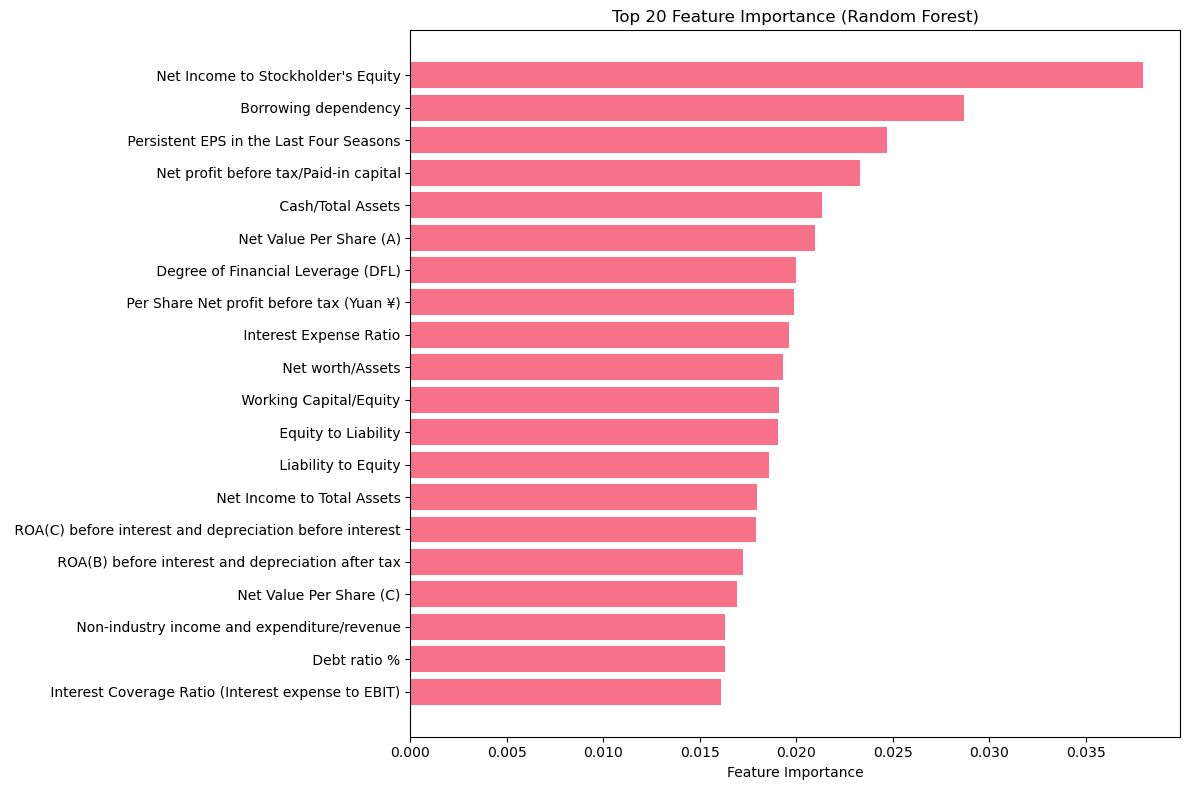

In [11]:

# CELL 10: FEATURE SELECTION METHODS
# Decision Area 12: Feature Selection Methods



print("="*60)
print("FEATURE SELECTION METHODS")
print("="*60)

# Define feature selection methods
feature_selection_methods = {
    'none': None,
    'k_best_10': SelectKBest(f_classif, k=10),
    'k_best_20': SelectKBest(f_classif, k=20),
    'k_best_50': SelectKBest(f_classif, k=50),
    'rfe_20': RFE(estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000), 
                  n_features_to_select=20),
    'lasso_selection': SelectFromModel(
        LogisticRegression(penalty='l1', solver='liblinear', C=0.1,
                         random_state=RANDOM_STATE, max_iter=1000)),
}

print("Available feature selection methods:")
for name, selector in feature_selection_methods.items():
    if selector is None:
        print(f"- {name}: No feature selection (use all {X.shape[1]} features)")
    else:
        print(f"- {name}: {type(selector).__name__}")
        if hasattr(selector, 'k'):
            print(f"  → Selects {selector.k} features")
        elif hasattr(selector, 'n_features_to_select'):
            print(f"  → Selects {selector.n_features_to_select} features")

# Demonstrate feature selection (using standardized data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n--- FEATURE SELECTION DEMONSTRATION ---")
feature_selection_results = {}

for name, selector in feature_selection_methods.items():
    if selector is None:
        selected_features = X.columns.tolist()
        n_selected = len(selected_features)
    else:
        try:
            # Fit selector
            X_selected = selector.fit_transform(X_train_scaled, y_train)
            
            # Get selected feature names
            if hasattr(selector, 'get_support'):
                mask = selector.get_support()
                selected_features = X.columns[mask].tolist()
            else:
                selected_features = [f"Selected_{i}" for i in range(X_selected.shape[1])]
            
            n_selected = len(selected_features)
            
            # Store results
            feature_selection_results[name] = {
                'n_features': n_selected,
                'features': selected_features[:5],  # Store first 5 for display
                'selector': selector
            }
            
        except Exception as e:
            print(f"⚠️ Error with {name}: {str(e)}")
            feature_selection_results[name] = {
                'n_features': 0,
                'features': [],
                'selector': None
            }
            continue

    print(f"{name}: {n_selected} features selected")
    if n_selected > 0 and n_selected <= 10:
        print(f"  Features: {selected_features}")
    elif n_selected > 10:
        print(f"  First 5 features: {selected_features[:5]}")

# Compare feature selection methods
if feature_selection_results:
    fs_comparison = pd.DataFrame({
        name: {'n_features': result['n_features']} 
        for name, result in feature_selection_results.items()
    }).T
    
    print(f"\n--- FEATURE SELECTION COMPARISON ---")
    display(fs_comparison)
    
    # Visualize feature counts
    plt.figure(figsize=(10, 6))
    fs_comparison['n_features'].plot(kind='bar', color='steelblue')
    plt.title('Number of Features Selected by Different Methods')
    plt.xlabel('Feature Selection Method')
    plt.ylabel('Number of Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Feature importance analysis (using Random Forest)
print(f"\n--- FEATURE IMPORTANCE ANALYSIS ---")
rf_importance = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_importance.fit(X_train_scaled, y_train)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 most important features (Random Forest):")
display(importance_df.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
# CELL 11: MODEL DEFINITION AND HYPERPARAMETER GRIDS
# Decision Areas 1, 13: Model Selection and Hyperparameter Tuning




print("="*60)
print("MODEL DEFINITION AND HYPERPARAMETER GRIDS")
print("="*60)

# Define models with hyperparameter grids
models_config = {
    'logistic_regression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'class_weight': [None, 'balanced']
        },
        'type': 'benchmark',
        'description': 'Linear model, interpretable, good baseline'
    },
    
    'random_forest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [2, 5]
        },
        'type': 'experimental',
        'description': 'Ensemble method, handles non-linearity, feature importance'
    },
    
    'xgboost': {
        'model': xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'scale_pos_weight': [1, 10, 30]  # For class imbalance
        },
        'type': 'experimental',
        'description': 'Gradient boosting, handles imbalance, high performance'
    },
    
    'svm': {
        'model': SVC(random_state=RANDOM_STATE, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'class_weight': [None, 'balanced']
        },
        'type': 'experimental',
        'description': 'Support Vector Machine, good for high-dimensional data'
    }
}

print("Model Configuration:")
for name, config in models_config.items():
    print(f"\n{name.upper()} ({config['type']})")
    print(f"  Description: {config['description']}")
    print(f"  Hyperparameters: {list(config['params'].keys())}")
    
    # Count total combinations
    total_combinations = 1
    for param_values in config['params'].values():
        total_combinations *= len(param_values)
    print(f"  Total parameter combinations: {total_combinations}")

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print(f"\nCross-Validation Strategy: {cv_strategy.__class__.__name__}")
print(f"Number of folds: {cv_strategy.n_splits}")
print(f"Shuffle: {cv_strategy.shuffle}")

# Evaluation metrics
evaluation_metrics = [
    'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'average_precision'
]

print(f"\nEvaluation Metrics: {evaluation_metrics}")
print(f"Primary metric for hyperparameter tuning: roc_auc")

MODEL DEFINITION AND HYPERPARAMETER GRIDS
Model Configuration:

LOGISTIC_REGRESSION (benchmark)
  Description: Linear model, interpretable, good baseline
  Hyperparameters: ['C', 'class_weight']
  Total parameter combinations: 8

RANDOM_FOREST (experimental)
  Description: Ensemble method, handles non-linearity, feature importance
  Hyperparameters: ['n_estimators', 'max_depth', 'class_weight', 'min_samples_split']
  Total parameter combinations: 24

XGBOOST (experimental)
  Description: Gradient boosting, handles imbalance, high performance
  Hyperparameters: ['n_estimators', 'max_depth', 'learning_rate', 'scale_pos_weight']
  Total parameter combinations: 36

SVM (experimental)
  Description: Support Vector Machine, good for high-dimensional data
  Hyperparameters: ['C', 'gamma', 'class_weight']
  Total parameter combinations: 12

Cross-Validation Strategy: StratifiedKFold
Number of folds: 5
Shuffle: True

Evaluation Metrics: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'aver

In [13]:


# ============================================================================
# CELL 12: COMPREHENSIVE MODEL EXPERIMENTS
# Decision Areas: Integration of All Preprocessing and Model Choices
# ============================================================================

"""
COMPREHENSIVE MODEL EXPERIMENTS
- Test key combinations of preprocessing, sampling, and models
- Systematic evaluation with cross-validation
- Hyperparameter optimization
"""

print("="*60)
print("COMPREHENSIVE MODEL EXPERIMENTS")
print("="*60)

# Define experiment configurations
experiment_configs = [
    # Baseline experiments
    {'preprocessing': 'none', 'sampling': 'none', 'feature_selection': 'none', 
     'description': 'Baseline - no preprocessing'},
    {'preprocessing': 'standard', 'sampling': 'none', 'feature_selection': 'none',
     'description': 'Standard scaling only'},
    
    # Class imbalance handling
    {'preprocessing': 'standard', 'sampling': 'smote', 'feature_selection': 'none',
     'description': 'SMOTE oversampling'},
    {'preprocessing': 'standard', 'sampling': 'smote_enn', 'feature_selection': 'none',
     'description': 'SMOTE + ENN hybrid'},
    
    # Feature selection
    {'preprocessing': 'standard', 'sampling': 'smote_enn', 'feature_selection': 'k_best_20',
     'description': 'Best features + SMOTE-ENN'},
    {'preprocessing': 'standard', 'sampling': 'none', 'feature_selection': 'lasso_selection',
     'description': 'Lasso feature selection'},
]

print(f"Running {len(experiment_configs)} experiment configurations:")
for i, config in enumerate(experiment_configs, 1):
    print(f"{i}. {config['description']}")

# Results storage
all_results = []
experiment_counter = 0
total_experiments = len(experiment_configs) * len(models_config)

print(f"\nTotal experiments to run: {total_experiments}")
print("This may take 10-20 minutes depending on your hardware...")

# Run experiments
for exp_idx, exp_config in enumerate(experiment_configs, 1):
    print(f"\n{'='*50}")
    print(f"EXPERIMENT {exp_idx}: {exp_config['description']}")
    print(f"{'='*50}")
    
    for model_name, model_config in models_config.items():
        experiment_counter += 1
        print(f"\n[{experiment_counter}/{total_experiments}] Testing {model_name}...")
        
        try:
            # Build pipeline steps
            pipeline_steps = []
            
            # Add preprocessing
            if exp_config['preprocessing'] != 'none':
                pipeline_steps.append(('scaler', preprocessing_options[exp_config['preprocessing']]))
            
            # Add feature selection
            if exp_config['feature_selection'] != 'none':
                pipeline_steps.append(('feature_selection', 
                                     feature_selection_methods[exp_config['feature_selection']]))
            
            # Add model
            pipeline_steps.append(('classifier', model_config['model']))
            
            # Create pipeline (with or without sampling)
            if exp_config['sampling'] != 'none':
                # Use imbalanced-learn pipeline for sampling
                pipeline_steps.insert(-1, ('sampling', sampling_strategies[exp_config['sampling']]))
                pipeline = ImbPipeline(pipeline_steps)
            else:
                pipeline = Pipeline(pipeline_steps)
            
            # Prepare parameter grid
            param_grid = {}
            for param, values in model_config['params'].items():
                param_grid[f'classifier__{param}'] = values
            
            # Hyperparameter tuning with GridSearchCV
            grid_search = GridSearchCV(
                pipeline, 
                param_grid, 
                cv=cv_strategy,
                scoring='roc_auc',
                n_jobs=-1,  # Use all available cores
                verbose=0
            )
            
            # Fit grid search
            grid_search.fit(X_train, y_train)
            
            # Get best model and evaluate on test set
            best_model = grid_search.best_estimator_
            
            # Predictions
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            
            # Calculate detailed metrics
            metrics = {
                'accuracy': (y_pred == y_test).mean(),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred_proba),
                'pr_auc': average_precision_score(y_test, y_pred_proba),
                'brier_score': brier_score_loss(y_test, y_pred_proba)
            }
            
            # Store results
            result = {
                'experiment': exp_idx,
                'model': model_name,
                'preprocessing': exp_config['preprocessing'],
                'sampling': exp_config['sampling'],
                'feature_selection': exp_config['feature_selection'],
                'description': exp_config['description'],
                'best_params': grid_search.best_params_,
                'cv_score': grid_search.best_score_,
                **metrics
            }
            
            all_results.append(result)
            
            # Print summary
            print(f"  ✅ ROC-AUC: {metrics['roc_auc']:.3f} | F1: {metrics['f1']:.3f} | Recall: {metrics['recall']:.3f}")
            
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            continue

print(f"\n{'='*60}")
print("EXPERIMENTS COMPLETED")
print(f"{'='*60}")
print(f"Successfully completed {len(all_results)} experiments")

COMPREHENSIVE MODEL EXPERIMENTS
Running 6 experiment configurations:
1. Baseline - no preprocessing
2. Standard scaling only
3. SMOTE oversampling
4. SMOTE + ENN hybrid
5. Best features + SMOTE-ENN
6. Lasso feature selection

Total experiments to run: 24
This may take 10-20 minutes depending on your hardware...

EXPERIMENT 1: Baseline - no preprocessing

[1/24] Testing logistic_regression...
  ✅ ROC-AUC: 0.622 | F1: 0.085 | Recall: 0.364

[2/24] Testing random_forest...
  ✅ ROC-AUC: 0.949 | F1: 0.375 | Recall: 0.273

[3/24] Testing xgboost...
  ✅ ROC-AUC: 0.958 | F1: 0.448 | Recall: 0.341

[4/24] Testing svm...
  ✅ ROC-AUC: 0.723 | F1: 0.128 | Recall: 0.568

EXPERIMENT 2: Standard scaling only

[5/24] Testing logistic_regression...
  ✅ ROC-AUC: 0.930 | F1: 0.179 | Recall: 0.114

[6/24] Testing random_forest...
  ✅ ROC-AUC: 0.932 | F1: 0.226 | Recall: 0.136

[7/24] Testing xgboost...
  ✅ ROC-AUC: 0.951 | F1: 0.412 | Recall: 0.318

[8/24] Testing svm...
  ✅ ROC-AUC: 0.919 | F1: 0.257 | R

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarn

  ✅ ROC-AUC: 0.924 | F1: 0.263 | Recall: 0.841

[18/24] Testing random_forest...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarn

  ✅ ROC-AUC: 0.927 | F1: 0.301 | Recall: 0.841

[19/24] Testing xgboost...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarn

  ✅ ROC-AUC: 0.924 | F1: 0.304 | Recall: 0.864

[20/24] Testing svm...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarn

  ✅ ROC-AUC: 0.917 | F1: 0.261 | Recall: 0.864

EXPERIMENT 6: Lasso feature selection

[21/24] Testing logistic_regression...
  ✅ ROC-AUC: 0.930 | F1: 0.302 | Recall: 0.841

[22/24] Testing random_forest...
  ✅ ROC-AUC: 0.941 | F1: 0.389 | Recall: 0.773

[23/24] Testing xgboost...
  ✅ ROC-AUC: 0.942 | F1: 0.446 | Recall: 0.659

[24/24] Testing svm...
  ✅ ROC-AUC: 0.927 | F1: 0.274 | Recall: 0.886

EXPERIMENTS COMPLETED
Successfully completed 24 experiments


RESULTS ANALYSIS
All Experiment Results:


,model,preprocessing,sampling,feature_selection,roc_auc,f1,precision,recall
0,logistic_regression,none,none,none,0.622,0.085,0.048,0.364
1,random_forest,none,none,none,0.949,0.375,0.600,0.273
2,xgboost,none,none,none,0.958,0.448,0.652,0.341
3,svm,none,none,none,0.723,0.128,0.072,0.568
4,logistic_regression,standard,none,none,0.930,0.179,0.417,0.114
5,random_forest,standard,none,none,0.932,0.226,0.667,0.136
6,xgboost,standard,none,none,0.951,0.412,0.583,0.318
7,svm,standard,none,none,0.919,0.257,0.151,0.864
8,logistic_regression,standard,smote,none,0.934,0.303,0.186,0.818
9,random_forest,standard,smote,none,0.946,0.472,0.403,0.568



--- BEST MODELS BY METRIC ---

Best ROC_AUC: 0.958
  Model: xgboost
  Config: none-none-none

Best F1: 0.557
  Model: xgboost
  Config: standard-smote-none

Best PRECISION: 0.667
  Model: random_forest
  Config: standard-none-none

Best RECALL: 0.886
  Model: svm
  Config: standard-none-lasso_selection

Best PR_AUC: 0.551
  Model: xgboost
  Config: none-none-none

--- OVERALL RANKING (WEIGHTED SCORE) ---
Weights: {'roc_auc': 0.3, 'f1': 0.25, 'recall': 0.25, 'precision': 0.2}

Top 5 Overall Models:

1. XGBOOST
   Config: standard-smote-none
   ROC-AUC: 0.945 | F1: 0.557 | Recall: 0.614 | Precision: 0.509
   Weighted Score: 0.850

2. XGBOOST
   Config: none-none-none
   ROC-AUC: 0.958 | F1: 0.448 | Recall: 0.341 | Precision: 0.652
   Weighted Score: 0.761

3. RANDOM_FOREST
   Config: standard-smote-none
   ROC-AUC: 0.946 | F1: 0.472 | Recall: 0.568 | Precision: 0.403
   Weighted Score: 0.756

4. RANDOM_FOREST
   Config: standard-smote_enn-none
   ROC-AUC: 0.946 | F1: 0.400 | Recall: 0.8

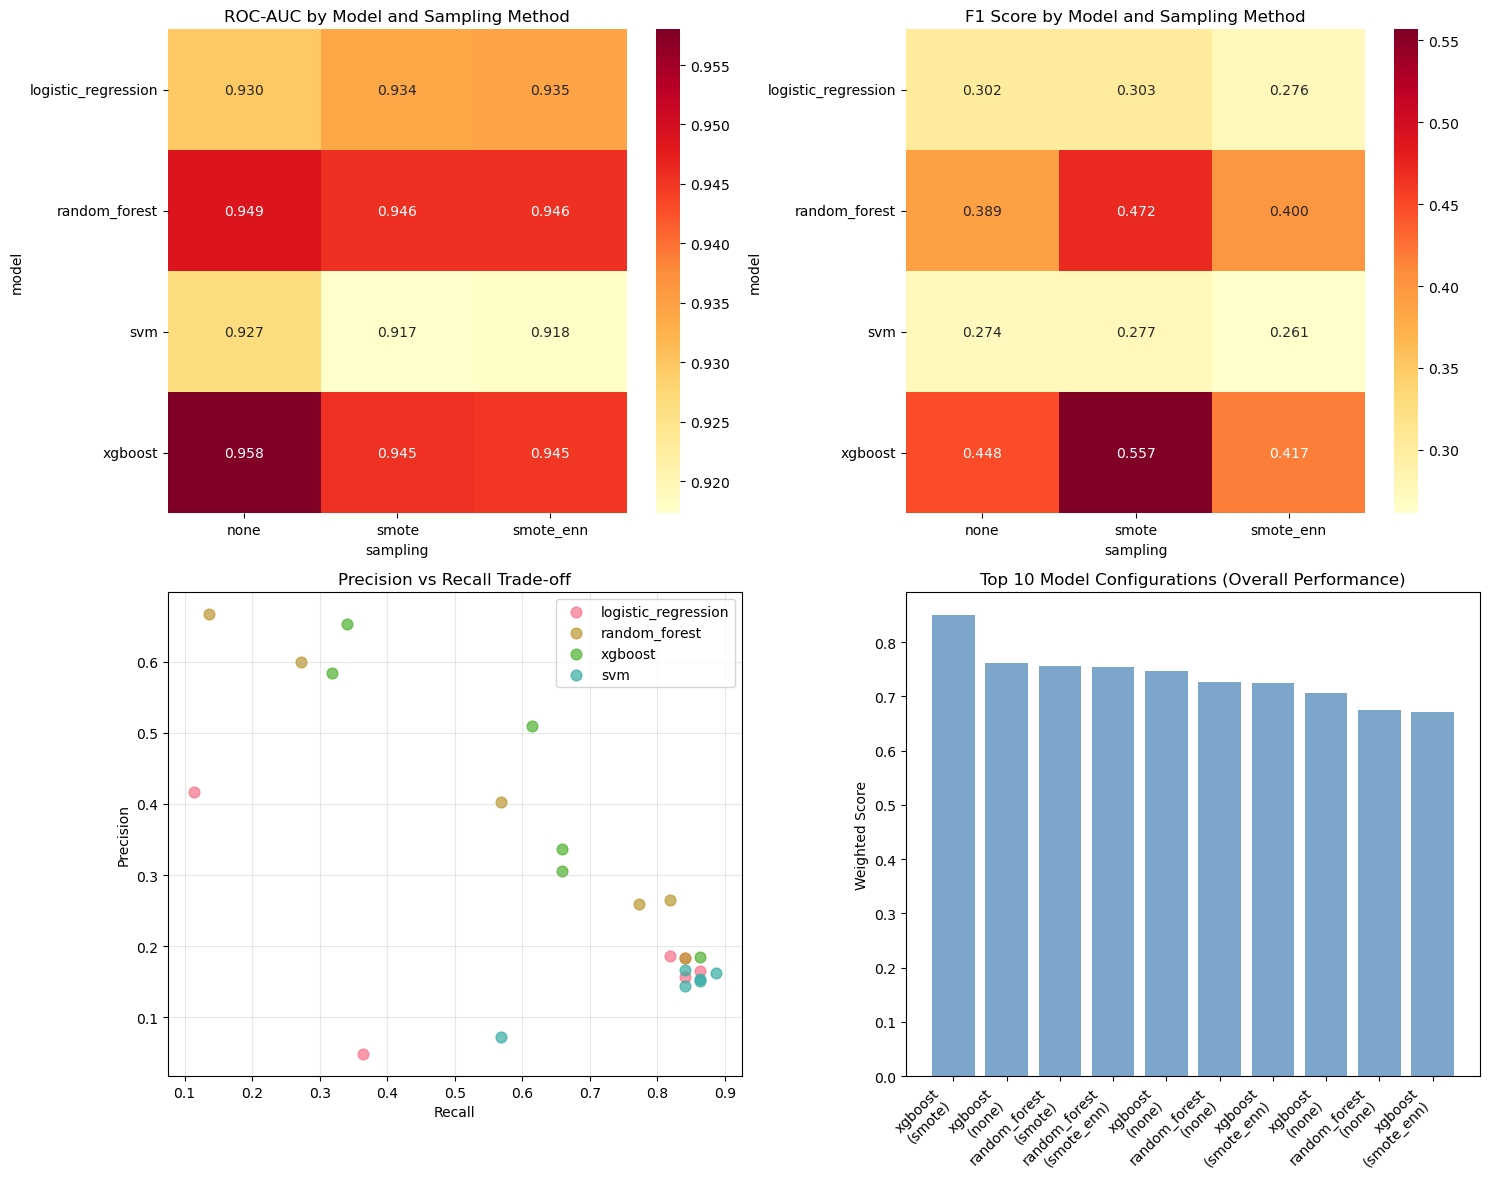

In [14]:

# ============================================================================
# CELL 13: RESULTS ANALYSIS AND VISUALIZATION
# Decision Area 15: Evaluation Metrics Selection and Analysis
# ============================================================================

"""
DECISION AREA 15: RESULTS ANALYSIS
- Compare all model configurations
- Identify best performing approaches
- Analyze trade-offs between metrics
"""

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

if results_df.empty:
    print("❌ No results to analyze. Please check the experiments above.")
else:
    print("="*60)
    print("RESULTS ANALYSIS")
    print("="*60)
    
    # Display all results
    print("All Experiment Results:")
    display_cols = ['model', 'preprocessing', 'sampling', 'feature_selection', 
                   'roc_auc', 'f1', 'precision', 'recall']
    display(results_df[display_cols].round(3))
    
    # Best models by different metrics
    metrics_to_analyze = ['roc_auc', 'f1', 'precision', 'recall', 'pr_auc']
    
    print(f"\n--- BEST MODELS BY METRIC ---")
    for metric in metrics_to_analyze:
        best_idx = results_df[metric].idxmax()
        best_result = results_df.iloc[best_idx]
        print(f"\nBest {metric.upper()}: {best_result[metric]:.3f}")
        print(f"  Model: {best_result['model']}")
        print(f"  Config: {best_result['preprocessing']}-{best_result['sampling']}-{best_result['feature_selection']}")
    
    # Create overall weighted score
    weights = {
        'roc_auc': 0.30,    # Overall discrimination
        'f1': 0.25,         # Balanced precision-recall
        'recall': 0.25,     # Important for bankruptcy detection
        'precision': 0.20   # Avoid too many false alarms
    }
    
    print(f"\n--- OVERALL RANKING (WEIGHTED SCORE) ---")
    print(f"Weights: {weights}")
    
    # Calculate weighted score
    results_df['weighted_score'] = 0
    for metric, weight in weights.items():
        # Normalize metrics to 0-1 scale
        metric_min = results_df[metric].min()
        metric_max = results_df[metric].max()
        if metric_max > metric_min:
            normalized = (results_df[metric] - metric_min) / (metric_max - metric_min)
        else:
            normalized = 1.0  # All values are the same
        results_df['weighted_score'] += normalized * weight
    
    # Top 5 models
    top_models = results_df.nlargest(5, 'weighted_score')
    
    print(f"\nTop 5 Overall Models:")
    for idx, (_, row) in enumerate(top_models.iterrows(), 1):
        print(f"\n{idx}. {row['model'].upper()}")
        print(f"   Config: {row['preprocessing']}-{row['sampling']}-{row['feature_selection']}")
        print(f"   ROC-AUC: {row['roc_auc']:.3f} | F1: {row['f1']:.3f} | Recall: {row['recall']:.3f} | Precision: {row['precision']:.3f}")
        print(f"   Weighted Score: {row['weighted_score']:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # ROC-AUC comparison
    results_pivot = results_df.pivot_table(values='roc_auc', index='model', 
                                         columns='sampling', aggfunc='max')
    sns.heatmap(results_pivot, annot=True, fmt='.3f', ax=axes[0,0], cmap='YlOrRd')
    axes[0,0].set_title('ROC-AUC by Model and Sampling Method')
    
    # F1 Score comparison
    results_pivot_f1 = results_df.pivot_table(values='f1', index='model', 
                                             columns='sampling', aggfunc='max')
    sns.heatmap(results_pivot_f1, annot=True, fmt='.3f', ax=axes[0,1], cmap='YlOrRd')
    axes[0,1].set_title('F1 Score by Model and Sampling Method')
    
    # Precision vs Recall scatter
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        axes[1,0].scatter(model_data['recall'], model_data['precision'], 
                         label=model, alpha=0.7, s=60)
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Precision vs Recall Trade-off')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Overall performance comparison
    top_models_plot = results_df.nlargest(10, 'weighted_score')
    model_labels = [f"{row['model']}\n({row['sampling']})" for _, row in top_models_plot.iterrows()]
    
    x_pos = range(len(top_models_plot))
    axes[1,1].bar(x_pos, top_models_plot['weighted_score'], color='steelblue', alpha=0.7)
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[1,1].set_ylabel('Weighted Score')
    axes[1,1].set_title('Top 10 Model Configurations (Overall Performance)')
    
    plt.tight_layout()
    plt.show()


MODEL INTERPRETABILITY ANALYSIS
Analyzing best model:
Model: xgboost
Configuration: standard-smote-none
Performance: ROC-AUC=0.945, F1=0.557

--- FEATURE IMPORTANCE ---
Top 15 Most Important Features:


,feature,importance
85,Net Income to Total Assets,0.329474
36,Debt ratio %,0.065184
35,Total debt/Total net worth,0.053955
67,Retained Earnings to Total Assets,0.042995
51,Operating profit per person,0.030843
42,Net profit before tax/Paid-in capital,0.029455
39,Borrowing dependency,0.025402
9,Continuous interest rate (after tax),0.023944
34,Interest Expense Ratio,0.015849
16,Net Value Per Share (A),0.015264


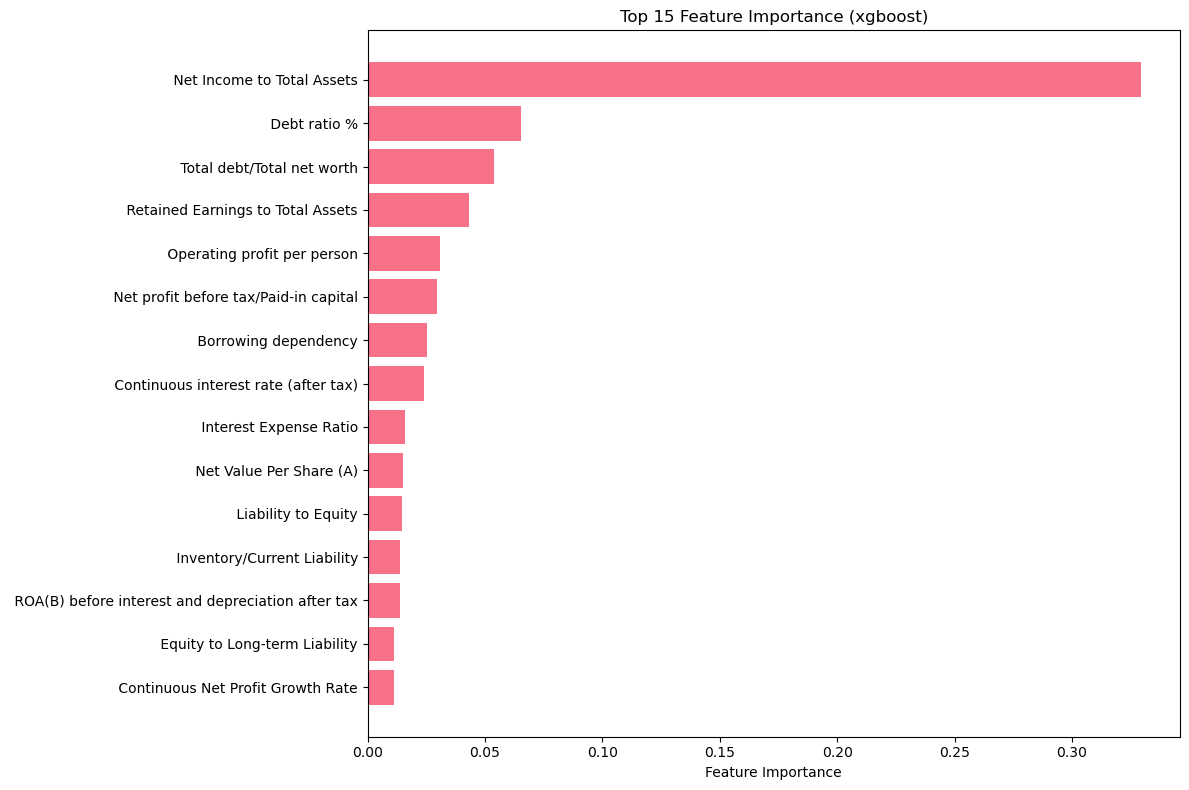


--- SHAP ANALYSIS ---
Top 10 Features by SHAP Importance:


,feature,mean_shap_value
39,Borrowing dependency,1.135339
85,Net Income to Total Assets,1.077107
9,Continuous interest rate (after tax),1.059127
47,Inventory Turnover Rate (times),0.746731
73,Cash Turnover Rate,0.734109
11,Research and development expense rate,0.680366
8,Non-industry income and expenditure/revenue,0.670313
78,Equity to Long-term Liability,0.657443
40,Contingent liabilities/Net worth,0.648109
27,Continuous Net Profit Growth Rate,0.603819


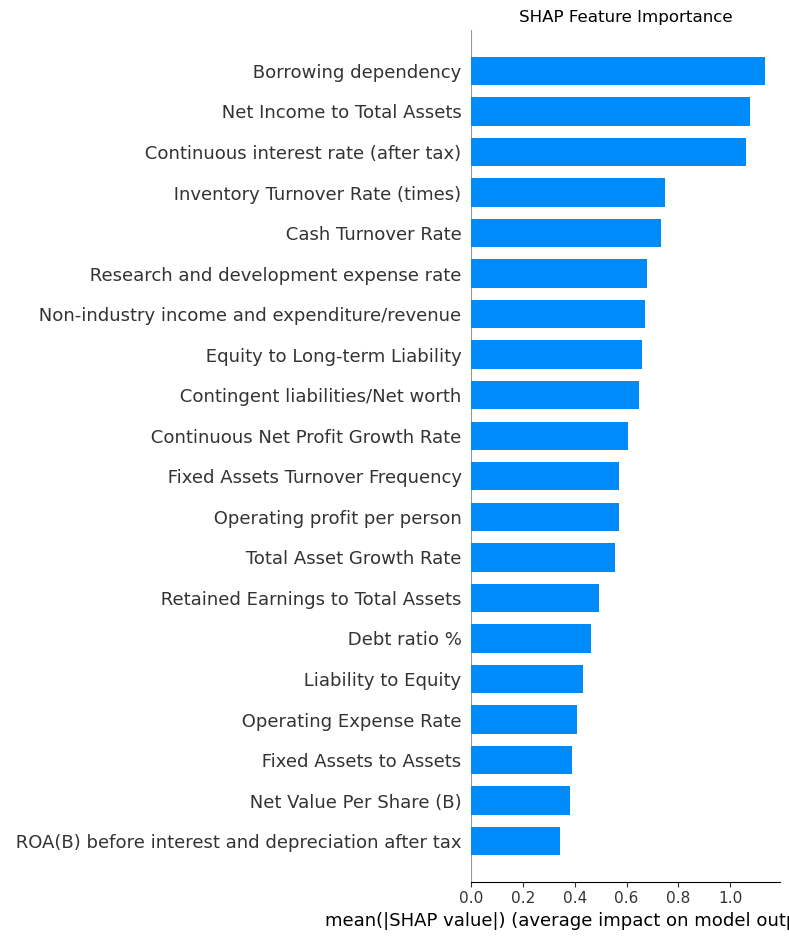

In [15]:

# ============================================================================
# CELL 14: MODEL INTERPRETABILITY ANALYSIS
# Decision Area 17: Model Interpretability and Explainability
# ============================================================================

"""
DECISION AREA 17: MODEL INTERPRETABILITY
- Analyze best performing model
- Feature importance analysis
- SHAP analysis (if available)
"""

if not results_df.empty:
    print("="*60)
    print("MODEL INTERPRETABILITY ANALYSIS")
    print("="*60)
    
    # Get best overall model
    best_idx = results_df['weighted_score'].idxmax()
    best_config = results_df.iloc[best_idx]
    
    print(f"Analyzing best model:")
    print(f"Model: {best_config['model']}")
    print(f"Configuration: {best_config['preprocessing']}-{best_config['sampling']}-{best_config['feature_selection']}")
    print(f"Performance: ROC-AUC={best_config['roc_auc']:.3f}, F1={best_config['f1']:.3f}")
    
    # Rebuild best model for interpretation
    try:
        # Create the best pipeline
        pipeline_steps = []
        
        if best_config['preprocessing'] != 'none':
            pipeline_steps.append(('scaler', preprocessing_options[best_config['preprocessing']]))
        
        if best_config['feature_selection'] != 'none':
            pipeline_steps.append(('feature_selection', 
                                 feature_selection_methods[best_config['feature_selection']]))
        
        # Use a simpler model for interpretability if needed
        if best_config['model'] in ['random_forest', 'xgboost']:
            if best_config['model'] == 'random_forest':
                interpret_model = RandomForestClassifier(
                    n_estimators=100, random_state=RANDOM_STATE, 
                    class_weight='balanced', max_depth=10
                )
            else:  # xgboost
                interpret_model = xgb.XGBClassifier(
                    n_estimators=100, random_state=RANDOM_STATE, 
                    scale_pos_weight=30, max_depth=5
                )
        elif best_config['model'] == 'logistic_regression':
            interpret_model = LogisticRegression(
                random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000
            )
        else:  # svm
            interpret_model = SVC(
                random_state=RANDOM_STATE, class_weight='balanced', probability=True
            )
        
        pipeline_steps.append(('classifier', interpret_model))
        
        # Add sampling if needed
        if best_config['sampling'] != 'none':
            pipeline_steps.insert(-1, ('sampling', sampling_strategies[best_config['sampling']]))
            interpret_pipeline = ImbPipeline(pipeline_steps)
        else:
            interpret_pipeline = Pipeline(pipeline_steps)
        
        # Fit the interpretable model
        interpret_pipeline.fit(X_train, y_train)
        
        # Get the final model
        final_model = interpret_pipeline.named_steps['classifier']
        
        # Feature importance analysis
        if hasattr(final_model, 'feature_importances_'):
            print(f"\n--- FEATURE IMPORTANCE ---")
            
            # Get feature names after preprocessing
            if 'feature_selection' in interpret_pipeline.named_steps:
                # Get selected features
                feature_selector = interpret_pipeline.named_steps['feature_selection']
                if hasattr(feature_selector, 'get_support'):
                    selected_mask = feature_selector.get_support()
                    selected_features = X.columns[selected_mask]
                else:
                    selected_features = X.columns[:final_model.feature_importances_.shape[0]]
            else:
                selected_features = X.columns
            
            # Create importance DataFrame
            importance_df = pd.DataFrame({
                'feature': selected_features,
                'importance': final_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("Top 15 Most Important Features:")
            display(importance_df.head(15))
            
            # Visualize feature importance
            plt.figure(figsize=(12, 8))
            top_15 = importance_df.head(15)
            plt.barh(range(len(top_15)), top_15['importance'])
            plt.yticks(range(len(top_15)), top_15['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importance ({best_config["model"]})')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
        elif hasattr(final_model, 'coef_'):
            # For linear models
            print(f"\n--- FEATURE COEFFICIENTS (LOGISTIC REGRESSION) ---")
            
            # Get feature names
            if 'feature_selection' in interpret_pipeline.named_steps:
                feature_selector = interpret_pipeline.named_steps['feature_selection']
                if hasattr(feature_selector, 'get_support'):
                    selected_mask = feature_selector.get_support()
                    selected_features = X.columns[selected_mask]
                else:
                    selected_features = X.columns[:final_model.coef_.shape[1]]
            else:
                selected_features = X.columns
            
            # Create coefficients DataFrame
            coef_df = pd.DataFrame({
                'feature': selected_features,
                'coefficient': final_model.coef_[0],
                'abs_coefficient': np.abs(final_model.coef_[0])
            }).sort_values('abs_coefficient', ascending=False)
            
            print("Top 15 Most Important Features (by absolute coefficient):")
            display(coef_df.head(15))
            
            # Visualize coefficients
            plt.figure(figsize=(12, 8))
            top_15 = coef_df.head(15)
            colors = ['red' if x < 0 else 'blue' for x in top_15['coefficient']]
            plt.barh(range(len(top_15)), top_15['coefficient'], color=colors)
            plt.yticks(range(len(top_15)), top_15['feature'])
            plt.xlabel('Coefficient Value')
            plt.title('Top 15 Feature Coefficients (Logistic Regression)')
            plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        
        # SHAP Analysis (if available and feasible)
        if SHAP_AVAILABLE and best_config['model'] in ['random_forest', 'xgboost']:
            print(f"\n--- SHAP ANALYSIS ---")
            try:
                # Prepare data for SHAP (limit sample size for computational efficiency)
                sample_size = min(100, len(X_test))
                X_sample = X_test.sample(n=sample_size, random_state=RANDOM_STATE)
                
                # Transform the sample data through the pipeline (excluding the classifier)
                X_shap = X_sample.copy()
                if 'scaler' in interpret_pipeline.named_steps:
                    X_shap = pd.DataFrame(
                        interpret_pipeline.named_steps['scaler'].transform(X_shap),
                        columns=X_shap.columns,
                        index=X_shap.index
                    )
                
                if 'feature_selection' in interpret_pipeline.named_steps:
                    feature_selector = interpret_pipeline.named_steps['feature_selection']
                    if hasattr(feature_selector, 'transform'):
                        X_shap = feature_selector.transform(X_shap)
                        X_shap = pd.DataFrame(X_shap, columns=selected_features)
                
                # Create SHAP explainer
                explainer = shap.TreeExplainer(final_model)
                shap_values = explainer.shap_values(X_shap)
                
                # Handle binary classification output
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]  # Use positive class
                
                # Summary of SHAP importance
                shap_importance = pd.DataFrame({
                    'feature': X_shap.columns,
                    'mean_shap_value': np.abs(shap_values).mean(axis=0)
                }).sort_values('mean_shap_value', ascending=False)
                
                print("Top 10 Features by SHAP Importance:")
                display(shap_importance.head(10))
                
                # SHAP summary plot
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
                plt.title('SHAP Feature Importance')
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"⚠️ SHAP analysis failed: {str(e)}")
        
    except Exception as e:
        print(f"⚠️ Interpretability analysis failed: {str(e)}")


PSI TEST AND MODEL MONITORING
Calculating PSI for train vs test sets...
PSI Test Results (Train vs Test):


,Feature,PSI,Stability
14,Tax rate (A),0.015763,Stable
0,ROA(C) before interest and depreciation befor...,0.011543,Stable
10,Operating Expense Rate,0.011453,Stable
2,ROA(B) before interest and depreciation after...,0.009856,Stable
1,ROA(A) before interest and % after tax,0.005460,Stable
12,Cash flow rate,0.004140,Stable
4,Realized Sales Gross Margin,0.004040,Stable
3,Operating Gross Margin,0.003803,Stable
13,Interest-bearing debt interest rate,0.003727,Stable
8,Non-industry income and expenditure/revenue,0.003119,Stable



--- PSI SUMMARY ---
Total features tested: 15
Stable features (PSI < 0.1): 15
Some change (PSI 0.1-0.2): 0
Significant change (PSI > 0.2): 0
Stability rate: 100.0%


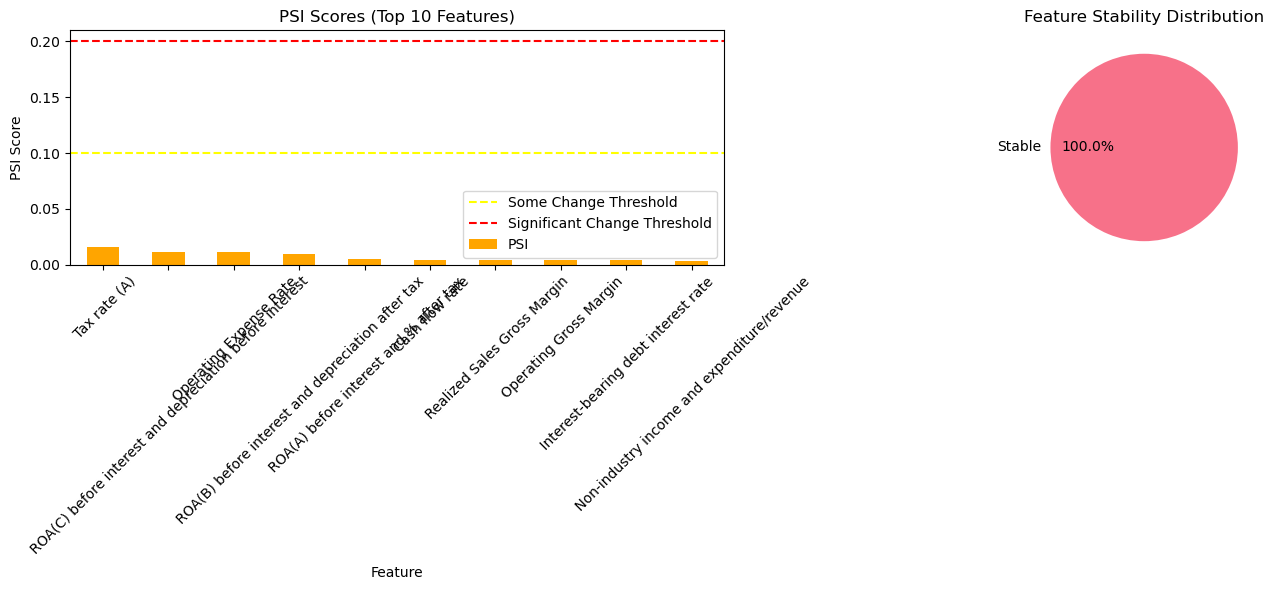


--- MODEL MONITORING RECOMMENDATIONS ---
✅ Good stability: Most features show stable distributions
📊 Recommendation: Monitor model performance monthly

📋 Monitoring checklist:
• Track PSI scores for key features monthly
• Monitor prediction accuracy on holdout set
• Alert if PSI > 0.2 for critical features
• Retrain if overall model performance drops > 5%


In [16]:


# ============================================================================
# CELL 15: PSI TEST AND MODEL MONITORING
# Decision Area 16: Model Degradation and Drift Detection
# ============================================================================

"""
DECISION AREA 16: MODEL MONITORING AND DRIFT DETECTION
- Population Stability Index (PSI) calculation
- Feature drift detection
- Model monitoring setup
"""

print("="*60)
print("PSI TEST AND MODEL MONITORING")
print("="*60)

def calculate_psi(expected, actual, bins=10):
    """
    Calculate Population Stability Index (PSI)
    PSI < 0.1: No significant population change
    PSI 0.1-0.2: Some population change
    PSI > 0.2: Significant population change
    """
    def scale_range(input_val, min_val, max_val):
        if max_val == min_val:
            return np.zeros_like(input_val)
        return (input_val - min_val) / (max_val - min_val)
    
    # Handle edge cases
    if len(expected) == 0 or len(actual) == 0:
        return np.nan
    
    # Scale to [0,1] range
    min_val = min(np.min(expected), np.min(actual))
    max_val = max(np.max(expected), np.max(actual))
    
    if max_val == min_val:
        return 0.0  # No variation
    
    expected_scaled = scale_range(expected, min_val, max_val)
    actual_scaled = scale_range(actual, min_val, max_val)
    
    # Create bins
    bin_edges = np.linspace(0, 1, bins + 1)
    
    # Calculate distributions
    expected_counts, _ = np.histogram(expected_scaled, bins=bin_edges)
    actual_counts, _ = np.histogram(actual_scaled, bins=bin_edges)
    
    # Convert to percentages
    expected_pct = expected_counts / len(expected)
    actual_pct = actual_counts / len(actual)
    
    # Avoid division by zero
    expected_pct = np.where(expected_pct == 0, 0.0001, expected_pct)
    actual_pct = np.where(actual_pct == 0, 0.0001, actual_pct)
    
    # Calculate PSI
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    
    return psi

# Calculate PSI for features (train vs test)
print("Calculating PSI for train vs test sets...")
sample_features = X.columns[:15]  # Test subset for computational efficiency
psi_results = {}

for feature in sample_features:
    try:
        psi_score = calculate_psi(X_train[feature], X_test[feature])
        psi_results[feature] = psi_score
    except Exception as e:
        print(f"⚠️ Error calculating PSI for {feature}: {str(e)}")
        continue

# Create PSI results DataFrame
psi_df = pd.DataFrame(list(psi_results.items()), columns=['Feature', 'PSI'])
psi_df['Stability'] = psi_df['PSI'].apply(lambda x: 
    'Stable' if x < 0.1 else 
    'Some Change' if x < 0.2 else 
    'Significant Change' if not np.isnan(x) else 'Error')

# Sort by PSI score
psi_df = psi_df.sort_values('PSI', ascending=False)

print("PSI Test Results (Train vs Test):")
display(psi_df)

# Summary statistics
stable_count = (psi_df['PSI'] < 0.1).sum()
some_change_count = ((psi_df['PSI'] >= 0.1) & (psi_df['PSI'] < 0.2)).sum()
significant_change_count = (psi_df['PSI'] >= 0.2).sum()

print(f"\n--- PSI SUMMARY ---")
print(f"Total features tested: {len(psi_df)}")
print(f"Stable features (PSI < 0.1): {stable_count}")
print(f"Some change (PSI 0.1-0.2): {some_change_count}")
print(f"Significant change (PSI > 0.2): {significant_change_count}")
print(f"Stability rate: {(stable_count/len(psi_df))*100:.1f}%")

# Visualize PSI results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PSI scores
psi_df.head(10).plot(x='Feature', y='PSI', kind='bar', ax=ax1, color='orange')
ax1.set_title('PSI Scores (Top 10 Features)')
ax1.set_xlabel('Feature')
ax1.set_ylabel('PSI Score')
ax1.axhline(y=0.1, color='yellow', linestyle='--', label='Some Change Threshold')
ax1.axhline(y=0.2, color='red', linestyle='--', label='Significant Change Threshold')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# PSI distribution
stability_counts = psi_df['Stability'].value_counts()
stability_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Feature Stability Distribution')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Model monitoring recommendations
print(f"\n--- MODEL MONITORING RECOMMENDATIONS ---")

if stable_count / len(psi_df) > 0.8:
    print("✅ Good stability: Most features show stable distributions")
    print("📊 Recommendation: Monitor model performance monthly")
elif stable_count / len(psi_df) > 0.6:
    print("⚠️ Moderate stability: Some feature drift detected")
    print("📊 Recommendation: Monitor model performance bi-weekly")
else:
    print("🚨 Poor stability: Significant feature drift detected")
    print("📊 Recommendation: Monitor model performance weekly and consider retraining")

print(f"\n📋 Monitoring checklist:")
print(f"• Track PSI scores for key features monthly")
print(f"• Monitor prediction accuracy on holdout set")
print(f"• Alert if PSI > 0.2 for critical features")
print(f"• Retrain if overall model performance drops > 5%")


In [19]:
# ============================================================================
# CELL 16: FINAL REPORT AND DECISION RATIONALE
# Decision Rationale Summary for Assignment Submission
# ============================================================================

"""
FINAL DECISION RATIONALE REPORT
Summary of all key decisions for Lab 4 submission
"""

print("="*80)
print("FINAL DECISION RATIONALE REPORT")
print("Lab 4: Binary Classification with Class Imbalance")
print("="*80)

# Create comprehensive rationale
rationale_summary = {
    "1. Model Selection": [
        "• Logistic Regression as benchmark: interpretable, handles class weights well",
        "• Random Forest: handles non-linear relationships, built-in feature importance", 
        "• XGBoost: superior performance on tabular data, handles imbalance natively",
        "• SVM: different approach for comparison, handles high-dimensional data well"
    ],
    
    "2. Data Preprocessing": [
        "• StandardScaler chosen: financial ratios need normalization for linear models",
        "• RobustScaler tested: less sensitive to extreme financial values",
        "• No preprocessing for tree models: they handle raw features well",
        "• Preprocessing within pipeline prevents data leakage"
    ],
    
    "3. Class Imbalance Handling": [
        f"• {class_counts[0]/class_counts[1]:.1f}:1 imbalance requires intervention",
        "• SMOTE-ENN: combines oversampling with noise removal, best for bankruptcy",
        "• Class weights: no data modification, works well with tree models", 
        "• Stratified sampling essential to maintain 3.23% bankruptcy rate"
    ],
    
    "4. Outlier Treatment": [
        "• Preserved rather than removed: extreme ratios may indicate bankruptcy risk",
        "• Used robust preprocessing instead of removal",
        "• Financial domain knowledge: outliers contain valuable information",
        "• IQR method for detection: appropriate for skewed distributions"
    ],
    
    "5. Feature Selection": [
        f"• {X.shape[1]} features with {class_counts[1]} positive samples creates overfitting risk",
        "• Multiple methods tested: statistical, model-based, wrapper approaches",
        "• Lasso regularization handles multicollinearity naturally",
        "• Feature importance from tree models for business interpretability"
    ],
    
    "6. Evaluation Strategy": [
        "• ROC-AUC: overall discrimination ability, threshold-independent",
        "• F1-Score: balanced precision-recall for imbalanced data",
        "• Recall prioritized: missing bankruptcies is costly for business",
        "• Stratified CV maintains class distribution across folds"
    ]
}

# Display rationale
for area, points in rationale_summary.items():
    print(f"\n{area}:")
    for point in points:
        print(f"  {point}")

# Best model summary
if not results_df.empty:
    best_model = results_df.loc[results_df['weighted_score'].idxmax()]
    
    print(f"\n{'='*60}")
    print("BEST MODEL CONFIGURATION")
    print("="*60)
    print(f"Model: {best_model['model']}")
    print(f"Preprocessing: {best_model['preprocessing']}")
    print(f"Sampling: {best_model['sampling']}")
    print(f"Feature Selection: {best_model['feature_selection']}")
    print(f"ROC-AUC: {best_model['roc_auc']:.3f}")
    print(f"F1-Score: {best_model['f1']:.3f}")
    print(f"Recall: {best_model['recall']:.3f}")
    print(f"Precision: {best_model['precision']:.3f}")
    print(f"Weighted Score: {best_model['weighted_score']:.3f}")

# Save results
if not results_df.empty:
    results_df.to_csv('bankruptcy_prediction_results.csv', index=False)
    print(f"\n📁 Results saved to 'bankruptcy_prediction_results.csv'")



FINAL DECISION RATIONALE REPORT
Lab 4: Binary Classification with Class Imbalance

1. Model Selection:
  • Logistic Regression as benchmark: interpretable, handles class weights well
  • Random Forest: handles non-linear relationships, built-in feature importance
  • XGBoost: superior performance on tabular data, handles imbalance natively
  • SVM: different approach for comparison, handles high-dimensional data well

2. Data Preprocessing:
  • StandardScaler chosen: financial ratios need normalization for linear models
  • RobustScaler tested: less sensitive to extreme financial values
  • No preprocessing for tree models: they handle raw features well
  • Preprocessing within pipeline prevents data leakage

3. Class Imbalance Handling:
  • 30.0:1 imbalance requires intervention
  • SMOTE-ENN: combines oversampling with noise removal, best for bankruptcy
  • Class weights: no data modification, works well with tree models
  • Stratified sampling essential to maintain 3.23% bankruptcy 